In [1]:
import pandas as pd
import numpy as np
import os
import sys
import datetime
import time
import math 


#from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler,Normalizer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, r2_score


import matplotlib.dates as mdates
import matplotlib.colors
import matplotlib.ticker as ticker

import pyart

import pytz
# import shap
import pickle
import multiprocessing

import cartopy.crs as ccrs

from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics.pairwise import haversine_distances
from math import radians


RANDOM_STATE = 42



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



# Perameters


In [6]:
folder = 'spatial'
node_id = '10004098'
dir_out = '../figures/' + folder + '/'
dir_data = '../data/'
dir_NEXRAD = '/Volumes/Backup Plus/NEXRAD/data/'

years = ['2019','2020'] ####
months = ['1','2','3','4','5','6','7','8','9','10','11','12']
days = np.array(range(1,31+1)).astype(str) #### np.array(range(1,31+1)).astype(str)
days = list(days)

hours = (np.array(range(0,24))).astype(str)
hours = list(hours)

bins = np.array(range(0,420+1)).astype(str)
bins = list(bins)
for i in range(len(bins)):
    bins[i] = 'Spectrum[' + bins[i] + ']'

wavelengths = np.array(range(360,780+1)).astype(str)
for i in range(len(wavelengths)):
    wavelengths[i] = wavelengths[i] + 'nm'
wavelengths = list(wavelengths)

/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Read Data

In [363]:
# if data has been preprocessed before, run this directly
fn_data = dir_data + 'driving_' + node_id + '.csv'
df = pd.read_csv(fn_data, parse_dates=True, index_col = 'UTC')
df = df[(df.index.date != datetime.date(2019, 12, 31)) # Minolta was covered in these dates
       &(df.index.date != datetime.date(2019, 12, 27))
       &(df.index.date != datetime.date(2020,  1,  1))
       &(df.index.date != datetime.date(2020,  1,  2))]
#        &(df.index.date != datetime.date(2020, 2, 14))
#        &(df.index.date != datetime.date(2020, 2, 21))] 

/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [369]:
# add x-y coordinates form the KFWS radar
filename = dir_NEXRAD + '2020-02-10/2020_02_10_KFWS_KFWS20200210_005713_V06'
radar = pyart.io.read_nexrad_archive(filename)

radar_lat = radar.latitude['data'][0]  # 32.57300186
radar_lon = radar.longitude['data'][0] # -97.30314636
projparams = {'proj': 'pyart_aeqd',
              'lon_0': radar_lon,
              'lat_0': radar_lat}

df['x'], df['y'] =  pyart.core.geographic_to_cartesian(df['longitude'], df['latitude'], projparams)


# grid parameters
step = 100 # grid resolution (meter) in x-y plane

z_0, delta_z = 0, 10000
num_z = int(delta_z // 1000) + 1

delta_y , delta_x  = 5000, 5000 # neighbor distance
delta_iy, delta_ix = int(delta_y / step), int(delta_x / step)


# add weights for Bilinear interpolation of radar data
df['res_y'], df['res_x'] =  (df['y'] % step) / step,  (df['x'] % step) / step
df['weight_y0x0'] = (1 - df['res_y']) * (1 - df['res_x'])
df['weight_y0x1'] = (1 - df['res_y']) *      df['res_x']
df['weight_y1x0'] =      df['res_y']  * (1 - df['res_x'])
df['weight_y1x1'] =      df['res_y']  *      df['res_x']

# neighbor parameters
neighbor = {
    ''  : (        0,         0),
    'N' : ( delta_iy,         0),
    'NE': ( delta_iy,  delta_ix),
    'E' : (        0,  delta_ix),
    'SE': (-delta_iy,  delta_ix),
    'S' : (-delta_iy,         0),
    'SW': (-delta_iy, -delta_ix),
    'W' : (        0, -delta_ix),
    'NW': ( delta_iy, -delta_ix)
}

/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [407]:
# date range
dates = np.unique(df.index.date)

# loop parameters
count = 0 # number of data records between the previous 2 radar files

for date in dates:
    yyyy_mm_dd = str(date)
    yyyy = yyyy_mm_dd[:4]
    mm = yyyy_mm_dd[5:7]
    dd = yyyy_mm_dd[-2:]
    
    filenames = os.listdir(dir_NEXRAD + yyyy_mm_dd + '/')
    filenames = [filename for filename in filenames if filename[-1]!= 'M']
    
    for i in range(len(filenames)):
        # find the previous radar datetime
        filename1 = filenames[i]
        HHMMSS1 = filename1[-10:-4]
        HH1, MM1, SS1 = HHMMSS1[:2], HHMMSS1[2:4], HHMMSS1[-2:]
        time1 = datetime.time(int(HH1), int(MM1), int(SS1))
        datetime1 = datetime.datetime.combine(date, time1)
        
        
        # find the next radar datetime
        if i < len(filenames)-1:
            date2 = date
            yyyy_mm_dd2 = str(date2)
            filename2 = filenames[i+1]
        else:
            if count == 0: # skip if the last count == 0
                continue
            # 1st file of the next day
            date2 = date + datetime.timedelta(days = 1)
            yyyy_mm_dd2 = str(date2)
            filenames2 = os.listdir(dir_NEXRAD + yyyy_mm_dd2 + '/')
            for filename2 in filenames2:
                if filename2[-1] != 'M':
                    break
                    
        HHMMSS2 = filename2[-10:-4]
        HH2, MM2, SS2 = HHMMSS2[:2], HHMMSS2[2:4], HHMMSS2[-2:]
        time2 = datetime.time(int(HH2), int(MM2), int(SS2))
        datetime2 = datetime.datetime.combine(date2, time2)
        
        
        # check if data exist between this time range
        index_i = (df.index > datetime1) & (df.index <= datetime2)
        count = index_i.sum()
        if count == 0:
            continue
        
        ###################################################################################
        ################# add NEXRAD data between datetime1 and datetime2 #################
        ###################################################################################
        df_i = df[index_i]
        path1 = dir_NEXRAD + yyyy_mm_dd + '/' + filename1
        path2 = dir_NEXRAD + yyyy_mm_dd + '/' + filename2
        
        time_start = time.time()
        radar1 = pyart.io.read_nexrad_archive(path1)
        radar2 = pyart.io.read_nexrad_archive(path2)
        
        # set up grid parameters
        x_min, x_max = (df_i['x'].min() // 100)* 100 - delta_x, (df_i['x'].max() // 100 + 1)* 100 + delta_x
        y_min, y_max = (df_i['y'].min() // 100)* 100 - delta_y, (df_i['y'].max() // 100 + 1)* 100 + delta_y
        
        num_x = int((x_max - x_min) // 100) + 1
        num_y = int((y_max - y_min) // 100) + 1
        
        grid1 = pyart.map.grid_from_radars(radar1, grid_shape=(num_z, num_y, num_x),\
                                           grid_limits=((z_0, z_0 + delta_z), (y_min, y_max), (x_min, x_max)))
        grid2 = pyart.map.grid_from_radars(radar2, grid_shape=(num_z, num_y, num_x),\
                                           grid_limits=((z_0, z_0 + delta_z), (y_min, y_max), (x_min, x_max)))
        
        fields1 = grid1.fields['reflectivity']['data'].filled(fill_value=-33)
        fields2 = grid2.fields['reflectivity']['data'].filled(fill_value=-33)
        
        
        print(datetime1, '  Running Time (s): ', time.time() - time_start)
        
        if i == 10:
            break
        
    break

/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 16:42:53   Running Time (s):  10.872055053710938


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 16:49:45   Running Time (s):  11.338356971740723


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 16:56:48   Running Time (s):  11.062307119369507


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 17:03:38   Running Time (s):  11.451047897338867


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 17:10:37   Running Time (s):  12.194087028503418


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 17:17:36   Running Time (s):  13.201268911361694


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 17:24:36   Running Time (s):  13.877989768981934


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 17:31:34   Running Time (s):  13.326534032821655


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 17:38:38   Running Time (s):  14.789137840270996


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 17:45:42   Running Time (s):  12.72845196723938


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 17:52:32   Running Time (s):  9.935633182525635


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 17:59:22   Running Time (s):  10.312239170074463


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 18:06:13   Running Time (s):  10.413589000701904


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 18:13:02   Running Time (s):  11.090374946594238


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 18:20:01   Running Time (s):  12.18180775642395


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 18:27:00   Running Time (s):  12.528618097305298


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 18:33:54   Running Time (s):  11.758265256881714


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 18:40:49   Running Time (s):  11.507410049438477


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 18:47:41   Running Time (s):  12.257291078567505


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 18:54:52   Running Time (s):  12.226417064666748


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 19:01:46   Running Time (s):  11.786526918411255


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 19:08:50   Running Time (s):  13.032503128051758


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 19:16:00   Running Time (s):  12.045623064041138


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 19:25:12   Running Time (s):  12.344529867172241


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 19:32:22   Running Time (s):  13.957731246948242


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 19:39:32   Running Time (s):  10.497077941894531


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 19:46:35   Running Time (s):  10.645751714706421


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 19:53:27   Running Time (s):  11.3103609085083


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 20:00:17   Running Time (s):  12.081071138381958


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 20:07:20   Running Time (s):  12.957919120788574


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 20:14:30   Running Time (s):  11.800524234771729


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 20:21:20   Running Time (s):  12.315493106842041


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 20:28:14   Running Time (s):  12.064934015274048


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 20:35:24   Running Time (s):  15.300625801086426


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 20:42:28   Running Time (s):  19.209162950515747


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."
/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


2020-01-08 20:49:28   Running Time (s):  17.696964025497437


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/pyart/map/gates_to_grid.py:163: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990.
  warnings.warn("Barnes weighting function is deprecated."


KeyboardInterrupt: 

In [374]:
df_i = df[index_i]
df_i.loc[:,'weight_t1'] = (datetime2 - df_i.index) / datetime_interval
df_i.loc[:,'weight_t2'] = (df_i.index - datetime1) / datetime_interval

iy = ((df_i.loc[:,'y'] - y_min)//100).astype(int)
ix = ((df_i.loc[:,'x'] - x_min)//100).astype(int)

for iz in range(num_z):
    for direction in neighbor:
        var = 'reflectivity_' + str(iz) + 'km'
        if direction:
            var += '_' + direction
        dix, diy = neighbor[direction]
        
        val_t1  = df_i.loc[:,'weight_y0x0'] * fields1[iz, iy+diy  , ix+dix  ] \
                + df_i.loc[:,'weight_y0x1'] * fields1[iz, iy+diy  , ix+dix+1] \
                + df_i.loc[:,'weight_y1x0'] * fields1[iz, iy+diy+1, ix+dix  ] \
                + df_i.loc[:,'weight_y1x1'] * fields1[iz, iy+diy+1, ix+dix+1] \
    
        val_t2  = df_i.loc[:,'weight_y0x0'] * fields2[iz, iy+diy  , ix+dix  ] \
                + df_i.loc[:,'weight_y0x1'] * fields2[iz, iy+diy  , ix+dix+1] \
                + df_i.loc[:,'weight_y1x0'] * fields2[iz, iy+diy+1, ix+dix  ] \
                + df_i.loc[:,'weight_y1x1'] * fields2[iz, iy+diy+1, ix+dix+1] \

        df_i.loc[:,var] = df_i.loc[:,'weight_t1'] * val_t1.loc[:] \
                        + df_i.loc[:,'weight_t2'] * val_t2.loc[:]


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


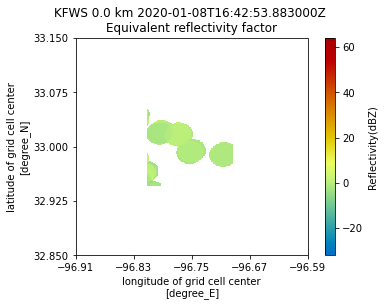

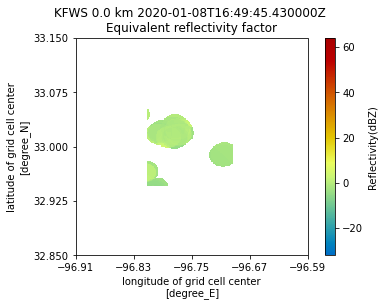

In [406]:
fig = plt.figure(figsize=[6,4])
display = pyart.graph.GridMapDisplay(grid1)
display.plot_grid('reflectivity', level=0, vmin=-32, vmax=64)


fig = plt.figure(figsize=[6,4])
display = pyart.graph.GridMapDisplay(grid2)
display.plot_grid('reflectivity', level=0, vmin=-32, vmax=64)


/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


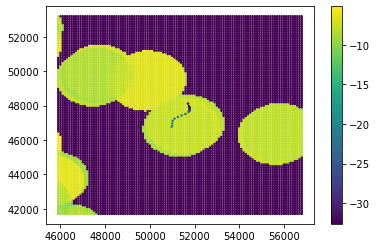

In [404]:
xx, yy = np.meshgrid(grid1.x['data'], grid1.y['data'])

plt.scatter(xx, yy, c = grid1.fields['reflectivity']['data'].filled(fill_value=-33)[0], s=2)


plt.scatter(df_i['x'], df_i['y'], c = df_i['reflectivity_0km'], s=2)

plt.colorbar()

/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


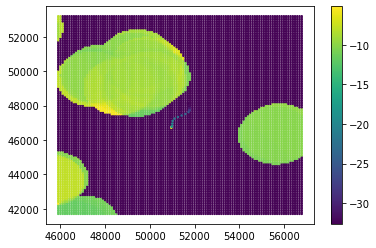

In [403]:
xx, yy = np.meshgrid(grid1.x['data'], grid1.y['data'])

plt.scatter(xx, yy, c = grid2.fields['reflectivity']['data'].filled(fill_value=-33)[0], s=2)

plt.scatter(df_i['x'], df_i['y'], c = df_i['reflectivity_0km'], s=2)

plt.colorbar()

/Users/Strawberry/opt/miniconda3/envs/geo_env/lib/python3.9/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


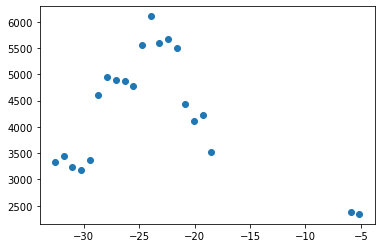

In [379]:
plt.scatter(df_i['reflectivity_1km'], df_i['Illuminance'])

In [5]:
print(df.columns[:]) # the last is UV Index
print('Sample Numbers: ',len(df))

Index(['Illuminance', '360nm', '361nm', '362nm', '363nm', '364nm', '365nm',
       '366nm', '367nm', '368nm',
       ...
       '777nm', '778nm', '779nm', '780nm', 'latitude', 'longitude', 'altitude',
       'Zenith', 'Azimuth', 'Sun Distance'],
      dtype='object', length=428)
Sample Numbers:  21508


## Spatial Plot on Map

In [5]:
# matlab

## Driving Temporal Variogram

In [6]:
var = 'Illuminance'
dh = 20

for date in set(df.index.date):    
    df1 = df[df.index.date == date]
    h = np.array([])
    variance = np.array([])
    for i in range(len(df1)):
        if i % 1000 == 0:
            print(i)
        ti = df1.index[i]
        f = df1.iloc[i][var]
    
        # distance in seconds
        h1 = abs(df1.index - df1.index[i]).seconds

        # variances before square root
        variance1 = (df1[var] - f).values**2

        # filter in time window (hours)

        h = np.append(h, h1)
        variance = np.append(variance, variance1)

    if len(gamma_day):
        h_day = np.array([])
        gamma_day = np.array([])
        dt_day = np.array([])
        for h_left in np.arange(0, h1.max()/50, dh):
            h_i = h_left + dh/2
            h_right = h_left + dh

            iwant = (h >= h_left) & (h < h_right)
            gamma_i = np.sqrt(variance[iwant].mean())

            h_day = np.append(h_day, h_i)
            gamma_day = np.append(gamma_day, gamma_i)

        plt.figure(figsize=(8, 6))
        plt.rcParams.update({'font.size': 15})
        plt.scatter(h_day, gamma_day,  s = 20)
        plt.xlabel('h / s')
        plt.ylabel('$\gamma$')
        plt.title('Variogram: ' + str(date) +  '\nrolling average by '+ str(dh)+ ' seconds ')
        plt.xlim(0,h_day.max())
        plt.ylim(0,np.nanmax(gamma_day)*1.1)
        plt.savefig(dir_out+'variogram_t_%02d_%02d_%02d_avg_%02ds.png' % (date.year, date.month, date.day, dh ))
        plt.close()

0


NameError: name 'gamma_day' is not defined

In [11]:
df1 = pd.read_csv('../data/driving_10004098.csv')

In [12]:
df2 = pd.read_csv('../data/driving_10004098_copy.csv')

In [26]:
df1.sum()

UTC             2020-01-08 16:43:502020-01-08 16:44:002020-01-...
Illuminance                                      164819401.631364
360nm                                                  570.886018
361nm                                                  585.650053
362nm                                                  607.658864
                                      ...                        
longitude                                         -2081818.832873
altitude                                           4361782.105476
Zenith                                             1259380.055975
Azimuth                                            3819338.998354
Sun Distance                                   3176506651592907.0
Length: 429, dtype: object

In [27]:
df2.sum()

UTC             2020-01-08 16:43:502020-01-08 16:44:002020-01-...
Illuminance                                      164819401.631364
360nm                                                  570.886018
361nm                                                  585.650053
362nm                                                  607.658864
                                      ...                        
longitude                                         -2081818.832873
altitude                                           4361782.105476
Zenith                                             1259380.055975
Azimuth                                            3819338.998354
Sun Distance                                   3176506651592916.0
Length: 429, dtype: object

## Spatial Variogram

In [8]:
h = np.array([])
variance = np.array([])
deltaT = np.array([])
for i in range(len(df1)):
    if i % 1000 == 0:
        print(i)
    long = df1.iloc[i]['longitude']
    lat = df1.iloc[i]['latitude']
    f = df1.iloc[i][var]
    
    # dx = dlong* cos lat
    dx = (df1['longitude'] - long).apply(math.radians) * np.cos(math.radians(df1['latitude'].mean()))
    # dy = dlat
    dy = (df1['latitude'] - lat).apply(math.radians)
    # ds = R*sqrt(dx^2 + dy^2)
    # distance in meters
    h1 = R*np.sqrt(dx*dx + dy*dy)
    
    # variances before square root
    variance1 = (df1[var] - f).values**2
    
    # filter in time window (hours)
    deltaT1 = abs(h1.index - df1.index[i])
    iwant = deltaT1 < datetime.timedelta(hours=0.5)
    
    h = np.append(h, h1[iwant])
    variance = np.append(variance, variance1[iwant])
    deltaT = np.append(deltaT, deltaT1[iwant].seconds)
    

0


NameError: name 'R' is not defined

In [7]:
for dh in [5,10,20,30,40,50,60,70,80,90,100]:
    h_day = np.array([])
    gamma_day = np.array([])
    dt_day = np.array([])
    for h_left in np.arange(0, h1.max(), dh):
        h_i = h_left + dh/2
        h_right = h_left + dh

        iwant = (h>=h_left) & (h < h_right)
        gamma_i = np.sqrt(variance[iwant].mean())

        h_day = np.append(h_day, h_i)
        gamma_day = np.append(gamma_day, gamma_i)

    plt.figure(figsize=(12, 10))
    plt.rcParams.update({'font.size': 15})
    plt.scatter(h_day, gamma_day,  s = 5)
    plt.xlabel('h / m')
    plt.ylabel('$\gamma$')
    plt.title('Variogram: ' + str(date) +  '\nrolling average by '+ str(dh)+ ' meters ')
    plt.xlim(0,6000)
    plt.ylim(0,5000)
    plt.savefig(dir_out+'variogram_%02d_%02d_%02d_avg_%02dm.png' % (date.year, date.month, date.day, dh ))
    plt.close()

/Users/Strawberry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
/Users/Strawberry/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [195]:
plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 15})
plt.scatter(h_day, gamma_day,  s = 5, c = dt_day)
plt.xlabel('h / m')
plt.ylabel('$\gamma$')
plt.title('Variogram: ' + str(date) +  '\nrolling average by '+ str(dh)+ ' meters ')
plt.ylim(0,5000)
plt.legend( loc='lower right')
plt.savefig(dir_out+'variogram_%02d_%02d_%02d_avg_%02dm.png' % (date.year, date.month, date.day, dh ))
plt.close()

No handles with labels found to put in legend.


In [9]:
# variogram each day
R = 6371 * 1000 # radius of earth

h = np.array([])
variance = np.array([])
for date in set(df.index.date):
    df1 = df[df.index.date == date]
    if df1['longitude'].std() < 1E-4:
        continue
    
    print(date,len(df1))
    h = np.array([])
    variance = np.array([])
    for i in range(len(df1)):
        if i % 1000 == 0:
            print(i)
        long = df1.iloc[i]['longitude']
        lat = df1.iloc[i]['latitude']
        f = df1.iloc[i][var]
        # dx = dlong* cos lat
        dx = (df1['longitude'] - long).apply(math.radians) * np.cos(math.radians(df1['latitude'].mean()))
        # dy = dlat
        dy = (df1['latitude'] - lat).apply(math.radians)
        # ds = R*sqrt(dx^2 + dy^2)
        
        h1 = R*np.sqrt(dx*dx + dy*dy)
        variance1 = (df1[var] - f).values**2

        h = np.append(h, h1)
        variance = np.append(variance, variance1)
    
    break
    

2020-01-23 680
0


In [194]:
np.cos(math.radians(df1['latitude'].mean()))

0.8385263740005442

In [276]:
features = [#'cloudPecentage', 'allRed', 'allGreen', 'allBlue',
            #'skyRed', 'skyGreen', 'skyBlue', 'cloudRed', 'cloudGreen', 'cloudBlue',
            'Violet', 'Blue', 'Green', 'Yellow', 'Orange', 'Red',
            'Temperature', 'Pressure', 'Humidity',
            #'Latitude', 'Longitude', 'Altitude',
            #'NH3', 'CO', 'NO2', 'C3H8', 'C4H10', 'CH4', 'H2', 'C2H5OH', 'CO2',
            'Luminosity', 'IR', 'Full', 'Visible', 'Lux',
            'UVA', 'UVB', 'Visible Compensation','IR Compensation', 'UV Index',
            'Zenith']
features = np.array(features)
len(features)

20

In [7]:
def showCorr(cols):
    size = len(cols)*0.8
    fig = plt.figure(figsize=(size, size))
    ax = fig.add_subplot(111)
    cax = ax.matshow(df[cols].corr(), cmap='RdBu')
    cax.set_clim(-1, 1);
    #plt.title('Correlation Matrix\n\n\n')
    fig.colorbar(cax)
    ax.set_xticklabels(np.append([""],cols), rotation=45, ha="left")
    ax.set_yticklabels(np.append([""],cols))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

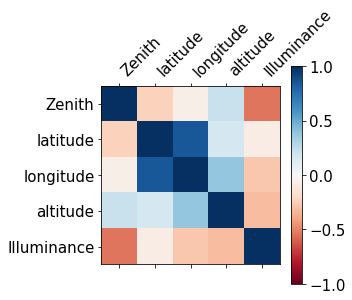

In [102]:
features = ['Zenith','latitude','longitude','altitude']
features = np.array(features)
target = 'Illuminance'
target_name = target # this is for display
X = df[features]
y = df[[target]] # MLP and scaler use multi output

showCorr(np.append(features, target))

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, df['Illuminance'], test_size=0.9, random_state=0)


In [31]:
from sklearn.feature_selection import mutual_info_regression
MIs = mutual_info_regression(X_train, y_train, n_neighbors=3)


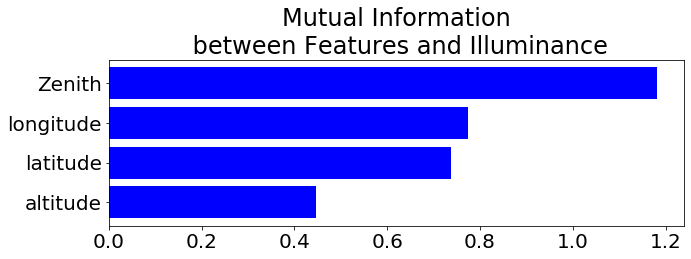

In [78]:
# rank feature inportance
num_features = len(features)
#std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)
indices = np.argsort(MIs)[::-1]

var_sorted = features[indices]
MIs_sorted = MIs[indices]

plt.rcParams["figure.figsize"] = (10, num_features) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
ax.barh(var_sorted[:num_features],
        MIs_sorted[:], color = 'blue',
        #yerr=std[indices][:num_features], ecolor='black',
        align="center")
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_title('Mutual Information\n between Features and Illuminance')
plt.tight_layout()
plt.savefig(dir_out + target + '/Mutual_Information_Illuminance.png')

# Clustering

In [103]:
# scale the data
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X)

#scaler_y = StandardScaler()
#y_scaled = scaler_y.fit_transform(y)


In [104]:
n_components = 4

DR = 'PCA'
Cluster = 'None'
pca = PCA(n_components=n_components, random_state = RANDOM_STATE)

X_PCA = pca.fit_transform(X_scaled)
X_PCA = pd.DataFrame(X_PCA)

print(pca.explained_variance_)


[2.02281938 1.23368275 0.62926542 0.11437729]


In [110]:
df_DR = X_PCA
df_DR[target] = y[target].values

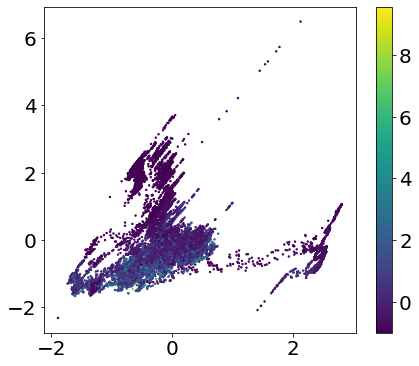

In [64]:
plt.rcParams["figure.figsize"] = (7, 6) # (w, h)
plt.rcParams.update({'font.size': 20})
plt.scatter(X_train_scaled_DR_scaled[:,0],X_train_scaled_DR_scaled[:,1],
            c=y_train_scaled[:,0], s = 2)
plt.colorbar()

In [81]:
DR = 'PCA'
Cluster = 'None'

# parameter for cluster, not for Dimension Reduction
n_clusters = 4
n_components = n_clusters

def scatter(data, var1, var2, clusters=[]):
    if len(clusters) == 0:
        clusters = np.zeros(len(data))
    fig = plt.figure(figsize=(7, 7))
    plt.rcParams.update({'font.size': 15})
    plt.scatter(data[var1], data[var2], c = clusters, s=20, cmap='jet')
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.title(target +
              '\nDimension Reduction: '+ DR +
              '\nCluster: ' + Cluster + ', n=' + str(n_clusters))
    #plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(dir_out + target + '/' + DR + '_' + Cluster + '_Scatter.png')
    plt.close()

In [71]:
X_PCA

array([[-0.36511779,  2.74025721, -0.3115687 ,  0.11235451],
       [ 0.00536547, -1.22362698, -0.14559533,  0.76815808],
       [ 3.61697441, -0.29088506, -0.27116608, -0.10809997],
       ...,
       [-0.93544508, -0.9477481 , -0.3202127 ,  0.20963503],
       [ 0.19822184, -0.66817237,  0.25360329,  0.00906931],
       [-0.85178221, -0.85101865, -0.09860724, -0.03830788]])

In [74]:
df_DR

,Zenith,latitude,longitude,altitude,target
0,-0.365118,2.740257,-0.311569,0.112355,-1.006823
1,0.005365,-1.223627,-0.145595,0.768158,-0.032894
2,3.616974,-0.290885,-0.271166,-0.108100,-0.700932
3,-0.072093,1.656253,0.944852,0.012146,-1.000358
4,-0.834458,2.005193,-1.297682,-0.086130,-1.006760
...,...,...,...,...,...
22089,0.035072,4.049017,0.239782,0.384140,-1.006783
22090,-0.038670,-0.324915,0.169305,-0.189426,-0.167492
22091,-0.935445,-0.947748,-0.320213,0.209635,1.422358
22092,0.198222,-0.668172,0.253603,0.009069,0.667466


In [88]:
# export dimension reduction data
X_PCA = X_train_scaled_DR

X_PCA = pd.DataFrame(X_train_scaled_DR)
df_DR = X_PCA.copy()
#df_DR.to_csv(dir_in + 'heart_'+ DR + '_' + Cluster +'.csv', index = False)


# EM
Cluster = 'EM'
em = GaussianMixture(n_components=n_components)
em.fit(X_PCA)
y_em = em.predict(X_PCA)
#centers = em.cluster_centers_
scatter(X_PCA,  X_PCA.columns[0], X_PCA.columns[1],  y_em)

# export EM data
df_DR_Cluster = df_DR.copy() 
df_DR_Cluster['Cluster'] = y_em
df_DR_Cluster[target] = y_train_scaled

#df_DR_Cluster.to_csv(dir_in + 'heart_'+ DR + '_' + Cluster +'.csv', index = False)


In [91]:
df_DR_Cluster

,0,1,2,3,Cluster,Illuminance
0,-0.365118,2.740257,-0.311569,0.112355,3,-1.006823
1,0.005365,-1.223627,-0.145595,0.768158,0,-0.032894
2,3.616974,-0.290885,-0.271166,-0.108100,1,-0.700932
3,-0.072093,1.656253,0.944852,0.012146,3,-1.000358
4,-0.834458,2.005193,-1.297682,-0.086130,3,-1.006760
...,...,...,...,...,...,...
22089,0.035072,4.049017,0.239782,0.384140,3,-1.006783
22090,-0.038670,-0.324915,0.169305,-0.189426,2,-0.167492
22091,-0.935445,-0.947748,-0.320213,0.209635,0,1.422358
22092,0.198222,-0.668172,0.253603,0.009069,2,0.667466


In [ ]:
# one-hot encoding
onehot_vars = ['Cluster']
for var in onehot_vars:
    df_add = pd.get_dummies(df_DR_Cluster[[var]].astype(str),prefix=[var], drop_first=True)
    df = pd.concat([df, df_add], axis=1)

df.drop(onehot_vars, axis=1, inplace=True)

# move target to the last column
df_target = df.pop('target') 
df['target'] = df_target

In [90]:
#hidden_layer_sizes=(32,64,128)
hidden_layer_sizes=(64,128,256)#
#hidden_layer_sizes=(128,128,128,128)
#hidden_layer_sizes=(150)
activation ='relu'
solver = 'adam'
alpha=1e-5 # L2 penalty (regularization term) parameter, default 1e-5
learning_rate = 'constant'

# include layer structure and activation function
structure = '_' + DR + str(n_components) + \
            '_' + str(hidden_layer_sizes)[1:-1].replace(', ','_') + \
            '_' + activation

In [42]:
start_time = time.time()


regr = MLPRegressor(random_state = RANDOM_STATE,
                    hidden_layer_sizes = hidden_layer_sizes,
                    activation = activation,
                    solver = solver,
                    alpha = alpha,
                    learning_rate = learning_rate,
                    verbose = True
                    )
regr.fit(X_train_scaled_DR_scaled, y_train_scaled)

# fine tune the model
regr.warm_start = True
regr.learning_rate_init /= 10 # default 0.001
regr.fit(X_train_scaled_DR_scaled, y_train_scaled)

regr.learning_rate_init /= 10 # default 0.001
regr.fit(X_train_scaled_DR_scaled, y_train_scaled)

print("--- %s seconds ---" % (time.time() - start_time))

/Users/Strawberry/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.24978304
Iteration 2, loss = 0.19766890
Iteration 3, loss = 0.18686484
Iteration 4, loss = 0.17985114
Iteration 5, loss = 0.17700322
Iteration 6, loss = 0.17277917
Iteration 7, loss = 0.16807567
Iteration 8, loss = 0.16515572
Iteration 9, loss = 0.16163736
Iteration 10, loss = 0.16254459
Iteration 11, loss = 0.15741617
Iteration 12, loss = 0.15371796
Iteration 13, loss = 0.14991794
Iteration 14, loss = 0.14903290
Iteration 15, loss = 0.14416498
Iteration 16, loss = 0.14437645
Iteration 17, loss = 0.14167055
Iteration 18, loss = 0.14014031
Iteration 19, loss = 0.13835518
Iteration 20, loss = 0.13468058
Iteration 21, loss = 0.13468341
Iteration 22, loss = 0.13261491
Iteration 23, loss = 0.13181999
Iteration 24, loss = 0.12880940
Iteration 25, loss = 0.12779694
Iteration 26, loss = 0.12384032
Iteration 27, loss = 0.12309710
Iteration 28, loss = 0.12328653
Iteration 29, loss = 0.12492425
Iteration 30, loss = 0.12093945
Iteration 31, loss = 0.12050412
Iteration 32, los

/Users/Strawberry/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/Strawberry/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 201, loss = 0.06046424
Iteration 202, loss = 0.05823911
Iteration 203, loss = 0.05800048
Iteration 204, loss = 0.05781358
Iteration 205, loss = 0.05765320
Iteration 206, loss = 0.05751840
Iteration 207, loss = 0.05741285
Iteration 208, loss = 0.05729673
Iteration 209, loss = 0.05715286
Iteration 210, loss = 0.05749360
Iteration 211, loss = 0.05709018
Iteration 212, loss = 0.05696343
Iteration 213, loss = 0.05698680
Iteration 214, loss = 0.05684813
Iteration 215, loss = 0.05680614
Iteration 216, loss = 0.05684098
Iteration 217, loss = 0.05680747
Iteration 218, loss = 0.05674410
Iteration 219, loss = 0.05663876
Iteration 220, loss = 0.05659056
Iteration 221, loss = 0.05657127
Iteration 222, loss = 0.05645306
Iteration 223, loss = 0.05662800
Iteration 224, loss = 0.05655155
Iteration 225, loss = 0.05632543
Iteration 226, loss = 0.05628983
Iteration 227, loss = 0.05628233
Iteration 228, loss = 0.05623468
Iteration 229, loss = 0.05634472
Iteration 230, loss = 0.05617977
Iteration 

/Users/Strawberry/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 314, loss = 0.05237504
Iteration 315, loss = 0.05214596
Iteration 316, loss = 0.05209610
Iteration 317, loss = 0.05204638
Iteration 318, loss = 0.05204958
Iteration 319, loss = 0.05203741
Iteration 320, loss = 0.05203714
Iteration 321, loss = 0.05201560
Iteration 322, loss = 0.05201285
Iteration 323, loss = 0.05205316
Iteration 324, loss = 0.05201425
Iteration 325, loss = 0.05199157
Iteration 326, loss = 0.05201714
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
--- 189.56539583206177 seconds ---


In [43]:
# save model
dir_model = '../models/' + folder + '/'
if not os.path.exists(dir_model):
    os.mkdir(dir_model)
dir_model +=  target + '/'
if not os.path.exists(dir_model):
    os.mkdir(dir_model)

fn_model = dir_model + target + structure + '.sav'
pickle.dump(regr, open(fn_model, 'wb'))


In [ ]:
# dir_model = '../models/' + folder + '/' + target + '/'
# fn_model = dir_model + target + structure + '.sav'
# regr = pickle.load(open(fn_model, 'rb'))

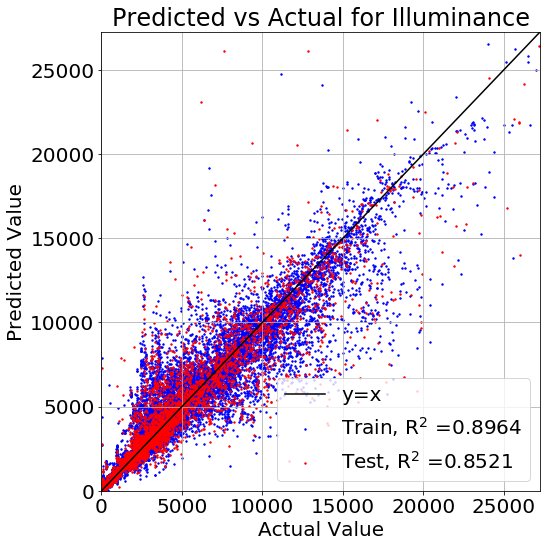

In [49]:
y_train_pred = scaler_y.inverse_transform(\
                    regr.predict( X_train_scaled_DR_scaled ).reshape(-1,1)
                    ) # for train
y_test_pred = scaler_y.inverse_transform(\
                    regr.predict( X_test_scaled_DR_scaled ).reshape(-1,1)
                    ) # for image

train_score =  r2_score(y_train, y_train_pred)
test_score = r2_score(y_test, y_test_pred)

y_min = 0
y_max = np.amax(y_train.values)*0.6
y_line = np.linspace(y_min,y_max,100)

plt.rcParams["figure.figsize"] = (8, 8) # (w, h)
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots()
plt.plot(y_line,y_line, '-k', label='y=x')
plt.scatter(y_train,y_train_pred, s=2, c = 'blue',label = 'Train, R$^{2}$ ='+str(train_score)[:6])
plt.scatter(y_test,y_test_pred, s=2, c = 'red', label = 'Test, R$^{2}$ ='+str(test_score)[:6])
plt.xlim((y_min,y_max))
plt.ylim((y_min,y_max))
ax.set_title('Predicted vs Actual for ' + target)
ax.set_xlabel('Actual Value')
ax.set_ylabel('Predicted Value')
plt.legend( loc='lower right')
plt.grid()
plt.tight_layout()

if not os.path.exists(dir_out + target):
    os.mkdir(dir_out + target)
plt.savefig(dir_out + target +'/MLP_performance_'+target+structure+'.png')


In [45]:
y_max

45418.560547

In [10]:
df.columns

Index(['Illuminance', '360nm', '361nm', '362nm', '363nm', '364nm', '365nm',
       '366nm', '367nm', '368nm',
       ...
       '775nm', '776nm', '777nm', '778nm', '779nm', '780nm', 'Zenith',
       'latitude', 'longitude', 'altitude'],
      dtype='object', length=426)

In [10]:
temp = df['latitude'].values.min()
print(temp)
temp//1,(temp%1)*60//1, ((temp%1)*60)%1*60//1

32.923808333333334


(32.0, 55.0, 25.0)

In [11]:
temp = df['latitude'].values.max()
print(temp)
temp//1,(temp%1)*60//1, ((temp%1)*60)%1*60//1

33.21573566666666


(33.0, 12.0, 56.0)

In [12]:
temp = df['longitude'].values.min()
print(temp)
temp//1,(temp%1)*60//1, ((temp%1)*60)%1*60//1

96.59482766666667


(96.0, 35.0, 41.0)

In [13]:
temp = df['longitude'].values.max()
print(temp)
temp//1,(temp%1)*60//1, ((temp%1)*60)%1*60//1

97.161448


(97.0, 9.0, 41.0)

In [ ]:
#  32.5,  33.5
# -97.5, -96.5



In [15]:
(96.59482766666667 + 97.161448)/2, (32.923808333333334+33.21573566666666)/2


(96.87813783333334, 33.069772)

## Google Earth Engine

In [ ]:
var geometry = 
    /* color: #d68480 */
    /* displayProperties: [
      {
        "type": "rectangle"
      }
    ] */
    ee.Geometry.Polygon(
        [[[-97.161448, 32.923808333333334],
          [-97.161448, 33.21573566666666],
          [-96.59482766666667, 33.21573566666666],
          [-96.59482766666667, 32.923808333333334]]], null, false);

In [ ]:
/**
 * Function to mask clouds based on the pixel_qa band of Landsat 8 SR data.
 * @param {ee.Image} image input Landsat 8 SR image
 * @return {ee.Image} cloudmasked Landsat 8 image
 */
function maskL8sr(image) {
  // Bits 3 and 5 are cloud shadow and cloud, respectively.
  var cloudShadowBitMask = (1 << 3);
  var cloudsBitMask = (1 << 5);
  // Get the pixel QA band.
  var qa = image.select('pixel_qa');
  // Both flags should be set to zero, indicating clear conditions.
  var mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0)
                 .and(qa.bitwiseAnd(cloudsBitMask).eq(0));
  return image.updateMask(mask);
}

var dataset = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')
                  .filterDate('2020-01-25', '2020-02-10')
                  .filterBounds(geometry)
                  .map(maskL8sr);

var visParams = {
  bands: ['B4', 'B3', 'B2'],
  min: 0,
  max: 3000,
  gamma: 1.4,
};
Map.setCenter(-96.87813783333334, 33.069772, 9);
Map.addLayer(dataset.median(), visParams);


Export.image.toDrive({
  image:dataset.median(),
  description:"landsat8",
  scale:30,
  region:geometry
});


In [30]:
set(df.index.date)

{datetime.date(2020, 1, 8),
 datetime.date(2020, 1, 9),
 datetime.date(2020, 1, 15),
 datetime.date(2020, 1, 16),
 datetime.date(2020, 1, 17),
 datetime.date(2020, 1, 23),
 datetime.date(2020, 1, 24),
 datetime.date(2020, 1, 25),
 datetime.date(2020, 1, 26),
 datetime.date(2020, 1, 27),
 datetime.date(2020, 1, 28),
 datetime.date(2020, 1, 29),
 datetime.date(2020, 1, 30),
 datetime.date(2020, 1, 31),
 datetime.date(2020, 2, 1),
 datetime.date(2020, 2, 2),
 datetime.date(2020, 2, 3),
 datetime.date(2020, 2, 7),
 datetime.date(2020, 2, 8),
 datetime.date(2020, 2, 9),
 datetime.date(2020, 2, 10),
 datetime.date(2020, 2, 11),
 datetime.date(2020, 2, 12),
 datetime.date(2020, 2, 13),
 datetime.date(2020, 2, 14),
 datetime.date(2020, 2, 15),
 datetime.date(2020, 2, 16),
 datetime.date(2020, 2, 17),
 datetime.date(2020, 2, 18),
 datetime.date(2020, 2, 19),
 datetime.date(2020, 2, 20),
 datetime.date(2020, 2, 21),
 datetime.date(2020, 2, 22),
 datetime.date(2020, 2, 23),
 datetime.date(2020, 2

In [31]:
datetime.date(2020, 1, 8),
# datetime.date(2020, 1, 15),
# datetime.date(2020, 1, 16),
datetime.date(2020, 1, 23),
datetime.date(2020, 1, 24),
# datetime.date(2020, 1, 30),
# datetime.date(2020, 1, 31),
datetime.date(2020, 2, 1),
datetime.date(2020, 2, 7),
# datetime.date(2020, 2, 8),
# datetime.date(2020, 2, 15),
# datetime.date(2020, 2, 16),
# datetime.date(2020, 2, 17),
# datetime.date(2020, 2, 24),
# datetime.date(2020, 2, 25),
# datetime.date(2020, 3, 18),
# datetime.date(2020, 3, 20),
# datetime.date(2020, 3, 26),
# datetime.date(2020, 3, 27),


(datetime.date(2020, 2, 7),)

In [19]:
fn_data = dir_data + 'LC08_CU_016014_20200114_20200129_C01_V01_SRB1.tif'

from PIL import Image
im = Image.open(fn_data)
im.show()

In [20]:
imarray = np.array(im)

In [21]:
imarray

array([[  469,   522,   664, ..., -9999, -9999, -9999],
       [  606,   427,   555, ..., -9999, -9999, -9999],
       [  708,   529,   632, ..., -9999, -9999, -9999],
       ...,
       [ 4835,  4840,  4783, ..., -9999, -9999, -9999],
       [ 4899,  4858,  4782, ..., -9999, -9999, -9999],
       [ 4935,  4917,  4860, ..., -9999, -9999, -9999]], dtype=int32)

(-584.8977731768597, 539.2639856384162, -312.2922078692653, 312.0552681765916)

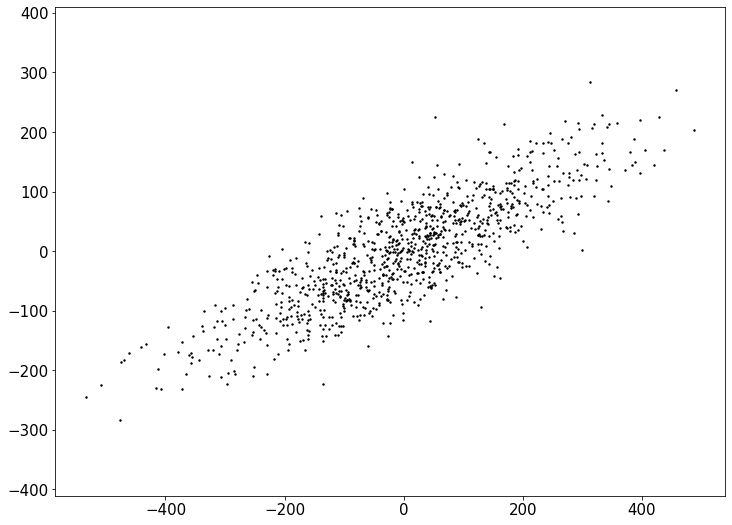

In [66]:
# PCA
plt.rcParams["figure.figsize"] = (12, 9) # (w, h)
plt.rcParams.update({'font.size': 15})

x0 = np.random.normal(0, 80, 1000)
y0 = np.random.normal(0, 20, 1000)

x1 = 2*x0 + y0
y1 = x0 - 2*y0

plt.scatter(x1,y1, 2, 'k')

plt.axis('equal')

(-780.9993556536605, 826.2922795296637, -309.4631267685153, 309.4631267685153)

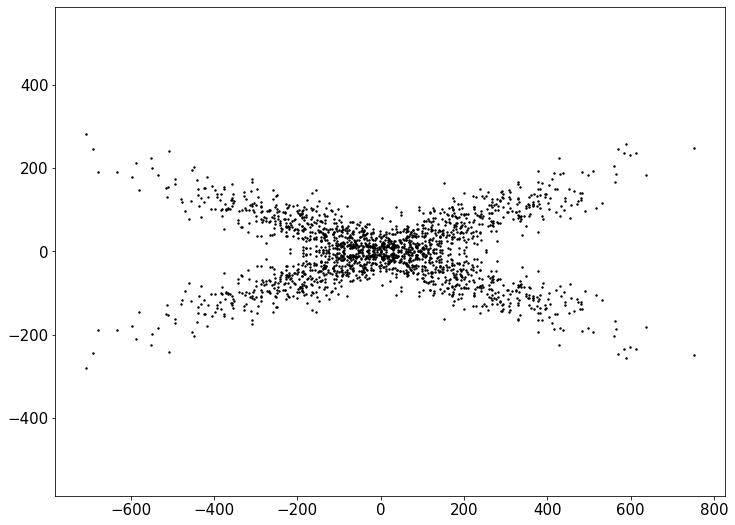

In [59]:
# ICA
plt.rcParams["figure.figsize"] = (12, 9) # (w, h)
plt.rcParams.update({'font.size': 15})

x0 = np.random.normal(0, 80, 1000)
y0 = np.random.normal(0, 10, 1000)

x1 = 3*x0 + y0
y1 = x0 - 3*y0

x2 = x1
y2 = -y1

plt.scatter(x1,y1, 2, 'k')
plt.scatter(x2,y2, 2, 'k')

plt.axis('equal')